<a href="https://colab.research.google.com/github/donw7/neural_activity_models_DNNs/blob/main/DNN_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding decision-making behavior from neural activity
This is a comparison of statistical models vs. deep neural networks (DNNs), their performances across different conditions and with various hyperparameters and types of neural data enabled by recent advances in cellular-resolution, brain-wide imaging.

## Hypotheses:
1. Decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small datasets
2. DNNs outperform statistical models but are prone to overfitting and require additional considerations, e.g. regularization

## Procedures:
1. Simulate neural data as validation of models to be used later with more complicated real neural data
2. Apply logistic regression
3. Apply recurrent neural networks (RNNs) and other DNNs
4. Compare DNNs to statistical models
5. Experimentation with optimizing hyperparameters

## Results & Conclusions summary:
- Complicated decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small and potentially noisy real-world datasets
- Interestingly, this suggests cellular information integrated across brain regions may work together for decision-making, a phenomenon that was previously technologically inaccessible
- DNNs outperform statistical models (logistic regression accuracy 30-40% whereas DNNs 50-60% vs. 30% expected by chance)
- DNNS are prone to overfitting and require additional considerations, e.g. crossvalidation or regularization
- XGBoost appears to be the best performing DNN (67% accuracy vs. 30% expected by chance)

## Future directions:
- further validation
- more systmatic hyperparameter tuning, e.g. grid search
- compare with other models, e.g. KNNs, SVM
- generalize to other types of data and conditions, such as EEG data in decision-making tasks
- prediction of real-time dynamics and how this may affect the performance of DNNs, e.g. less structural and more sequential information

## Acknowledgements:
- basic notebook adapted from KordingLab, with added data, analyses, and custom scripts, visualizations
- real neural activity data from Steinmetz et al., 2019

# Background
Neuropixels recordings from Steinmetz et al., 2019 of mice engaging in visual decision-making task. Probes are targeted near visual cortex but as indicated below are distributed brain-wide. Here we will use this rich, already preprocessed data to try to predict choices from 1 s of neural activity prior to choice. 

"Mice earned water rewards by turning a wheel to indicate which of two visual gratings had higher contrast, or by not turning if no stimulus was presented. When stimuli had equal contrast, a left or right choice was rewarded with 50% probability."

Paradigm: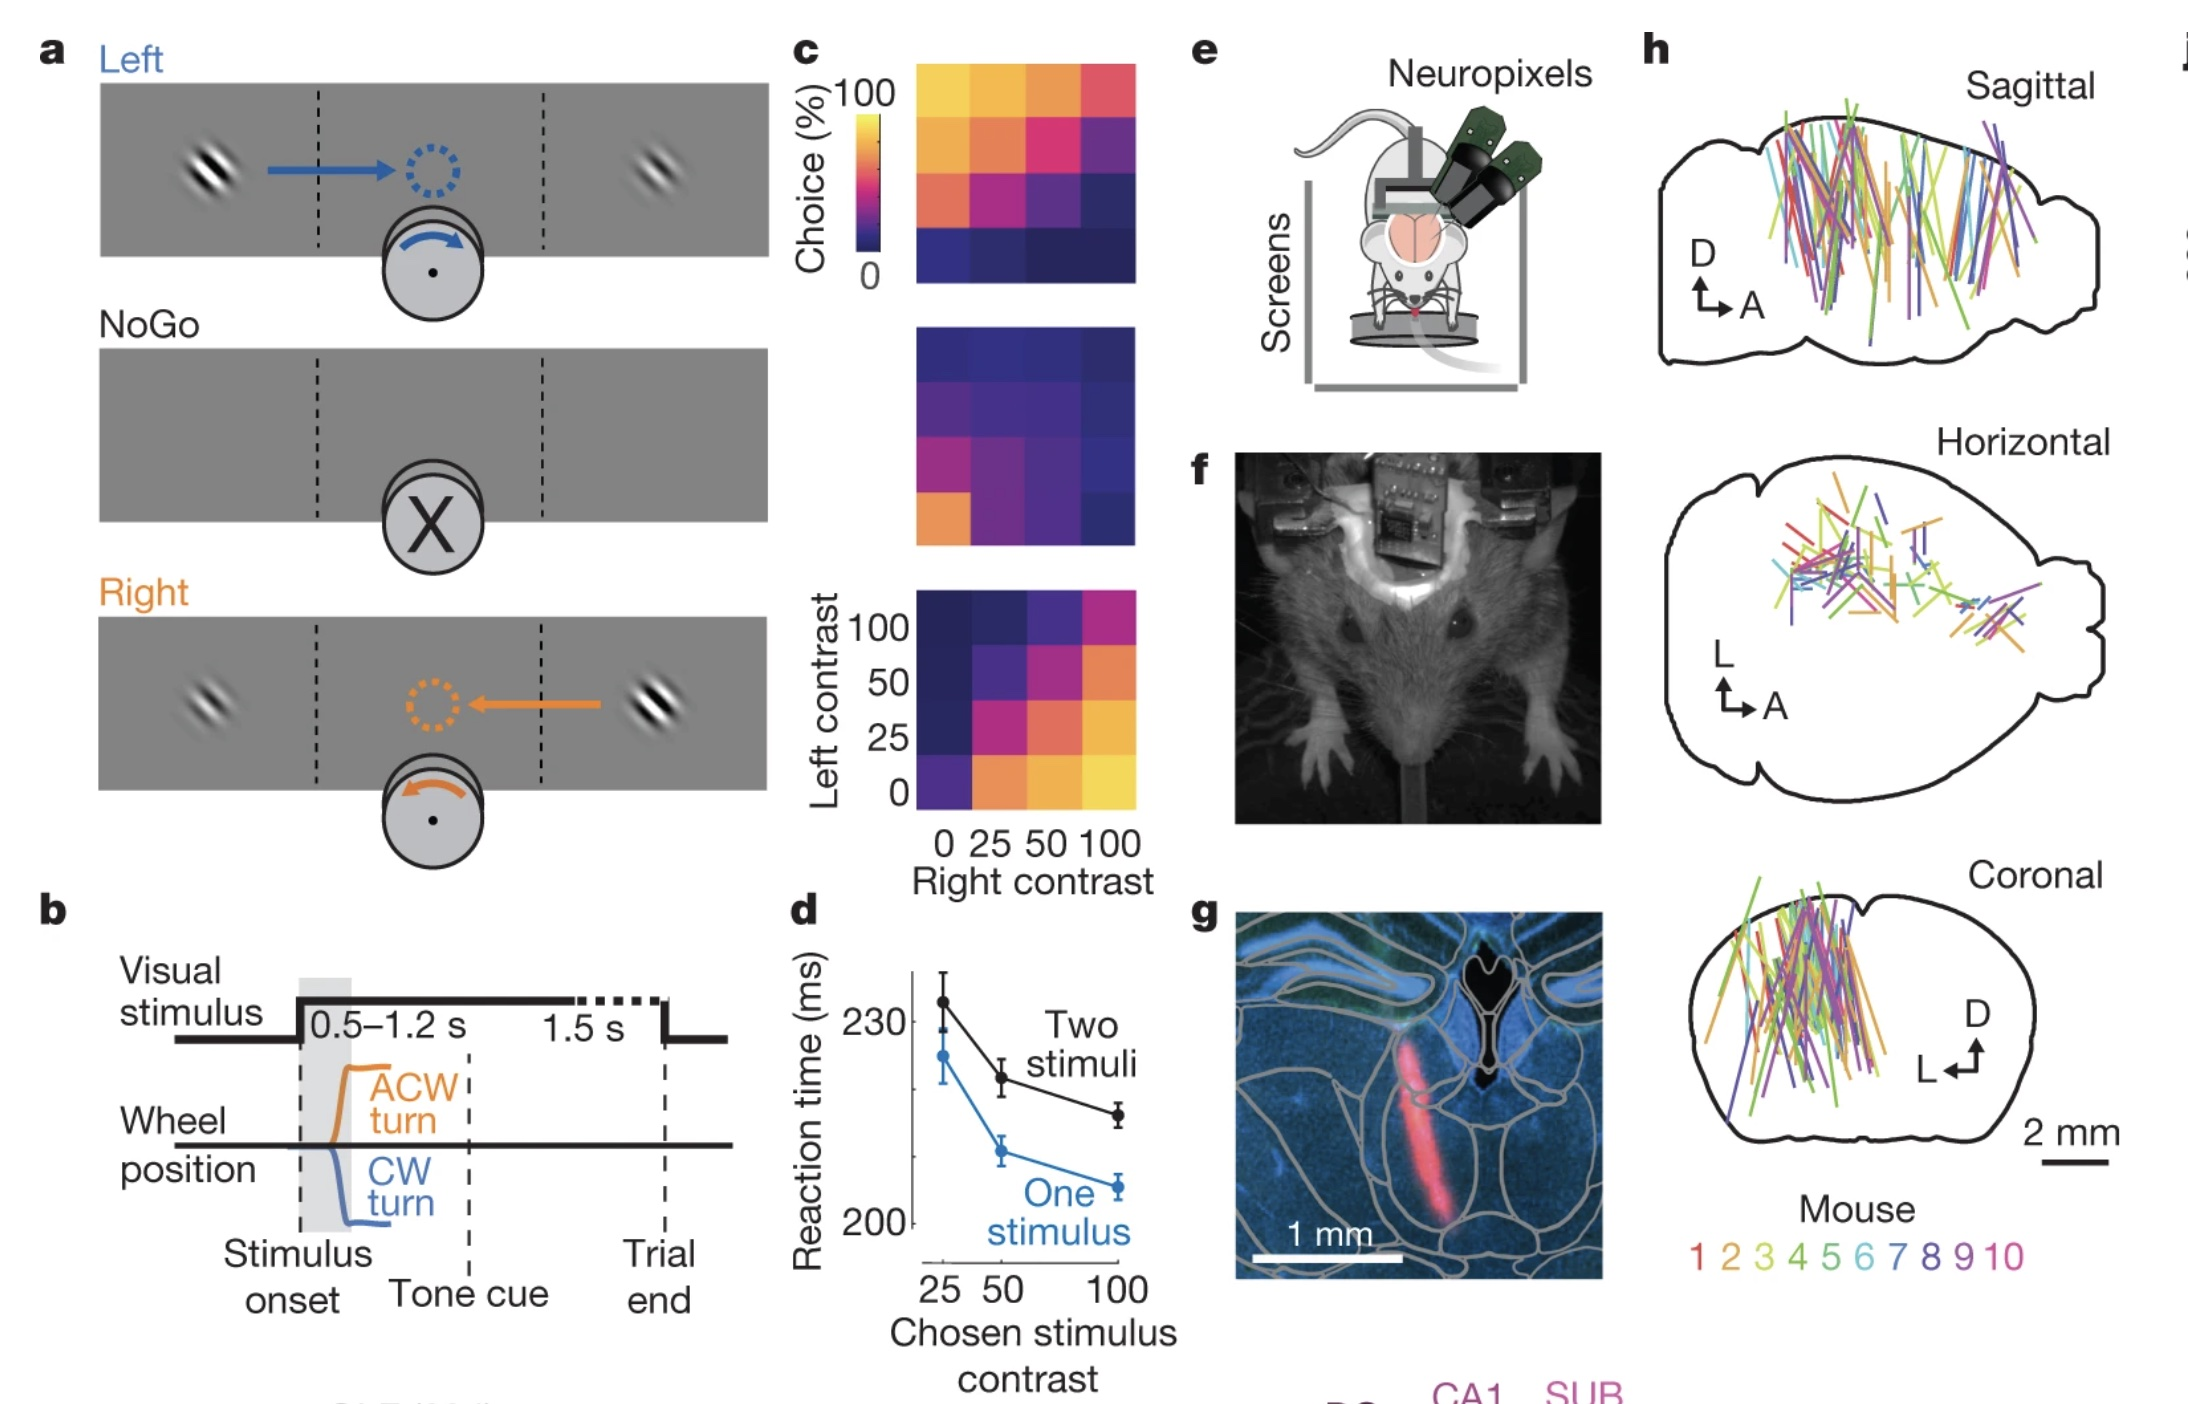

# Set up paths & import modules

### conditional mounting and path personalization

In [1]:
if "google.colab" in str(get_ipython()):
  print("running on colab, mounting")
  from google.colab import drive
  drive.mount("/content/drive")
  
  # personalize to path
  %cd "/content/drive/MyDrive/Colab Notebooks and Projects/neural_activity_models_DNNs-main"
  %ls
else:
  print("not running on colab")



running on colab, mounting
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks and Projects/neural_activity_models_DNNs-main
Binned_data.zip    DNN_decoding.ipynb  myplotfns.py
binned_spikes.npy  generate.py         neural-sequence_transformers_v2.ipynb
choices.npy        LICENSE             __pycache__/
decoders.py        mycrossval.py       README.md


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import warnings

import sklearn
from sklearn import linear_model

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
# custom modules
import generate
import decoders
warnings.filterwarnings('ignore')
import myplotfns
import mycrossval



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download data

In [4]:
gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)


In [5]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1
print(binned_spikes.shape, choices.shape)
print(choices[:10])


(228, 1089, 50) (228,)
[2. 2. 0. 0. 0. 1. 0. 0. 0. 2.]


# Initial vizualization of neural data structure

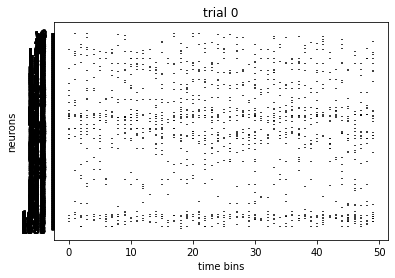

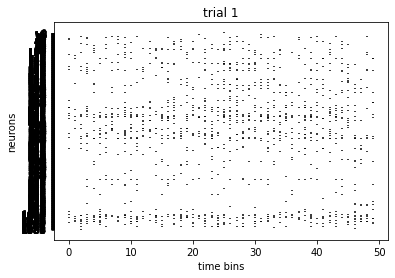

In [6]:
# print binned spikes event plots
displayidx = range(2) # trial indices to display
for di in displayidx:
  df_spikes_trial = pd.DataFrame(binned_spikes[di,:,:].T)
  positions = df_spikes_trial.apply(lambda x: df_spikes_trial.index[x == 1])
  plt.figure(di)
  plt.eventplot(positions, linelengths=2, lineoffsets=1, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  plt.ylabel('neurons')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).



# Set up cross validation and regularization

We will set up custom cross validation from scratch in order have more control when comparing models on a iteration to iteration basis, ensuring fairer comparisons. 

## simulate neural data to set up and as validation later
Since the goal is to analyze complicated real neural data, which would be less well-validated and subject to more noisy real world conditions, it would be prudent to start with analysis of simple simulated data to do some quick and dirty testing of regularization and cross validation parameters

Later, we will use this simulated data again as a positive control in order to rule out technical issues either in the data collection or model application process. 

In [7]:
# generate some simulated trial & neural data (drift diffusion model)
n_trials = 250
n_neurons = 10
n_bins_per_trial = 50

# shape n_trials x n_neurons x n_bins
neural_recordings, decisions = generate.neural_data(n_trials,
                                                    n_neurons,
                                                    n_bins_per_trial)

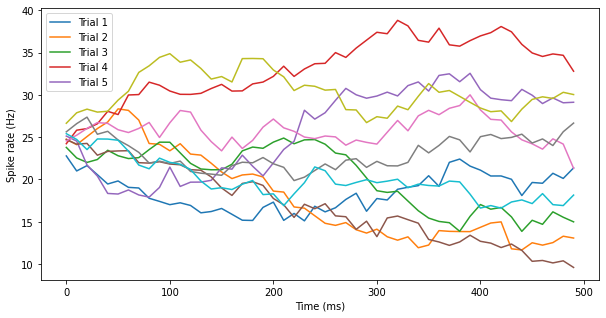

In [8]:
# plot out some trials for one neuron
neuron_id = 0

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,500,10),neural_recordings[:10,neuron_id,:].T)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(["Trial {}".format(i) for i in range(1,6)])

## obtain k-fold cross validation splits

In [9]:
# flatten
X = np.reshape(neural_recordings, (n_trials,-1))

(training_X, training_Y), (val_X, val_Y) = mycrossval.get_test_train_splits(X, decisions)

## no regularization

Fold 0 of 5
   Validation accuracy of 0.8


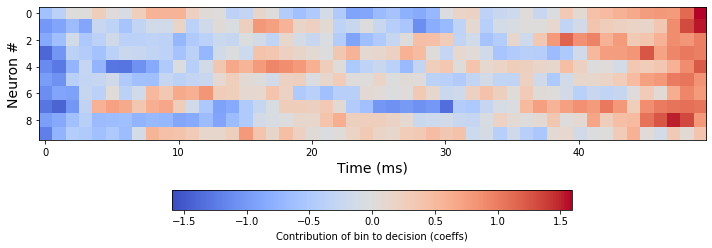

Fold 1 of 5
   Validation accuracy of 0.82


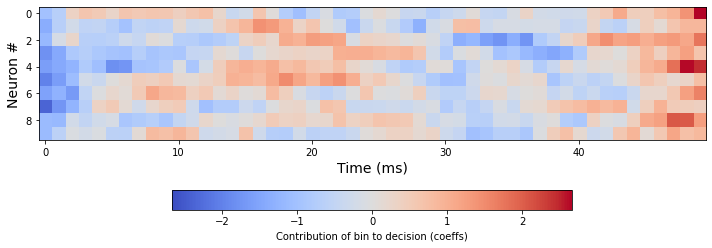

Fold 2 of 5
   Validation accuracy of 0.88


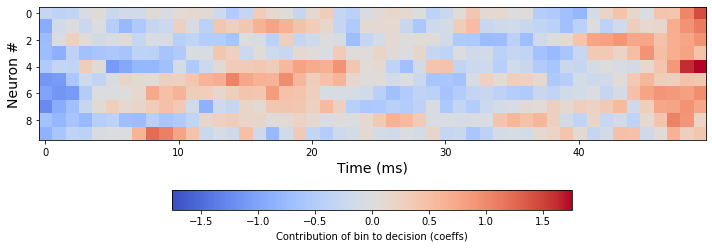

Fold 3 of 5
   Validation accuracy of 0.8


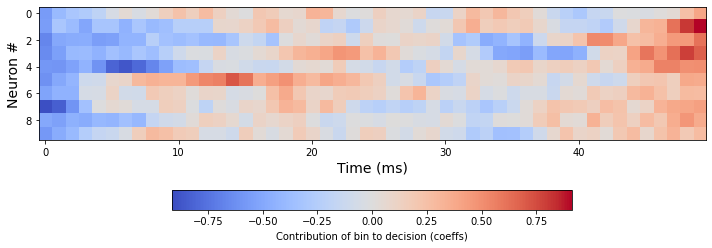

Fold 4 of 5
   Validation accuracy of 0.84


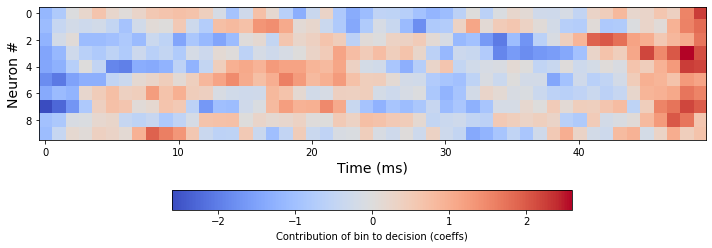

Mean validation accuracy: 0.828


In [11]:
scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_Xi = training_X[fold]
  training_Yi = training_Y[fold]
  
  val_Xi = val_X[fold]
  val_Yi = val_Y[fold]
  
  # re-initialize the logistic regression model
  logreg_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                               max_iter = 1000)
  # fit and score on training
  logreg_model.fit(training_Xi, training_Yi)
  logreg_model.score(training_Xi, training_Yi)

  # score on the validation data
  accuracy = logreg_model.score(val_Xi, val_Yi)
  scores.append(accuracy)
  
  print("   Validation accuracy of {}".format( accuracy ))
  
  myplotfns.plot_coefs(logreg_model, n_neurons, n_bins_per_trial)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

Accuracy strangely high but will see anyway

## experiment with regularization
Small datasets are especially prone to outsized weighting of noise or outliers, would like to implement regularization and compare for any initially obvious anomalies. 

### try initial value

Fold 0 of 5
   Validation accuracy of 0.8


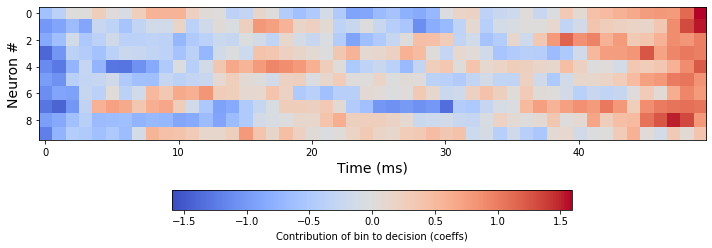

Fold 1 of 5
   Validation accuracy of 0.82


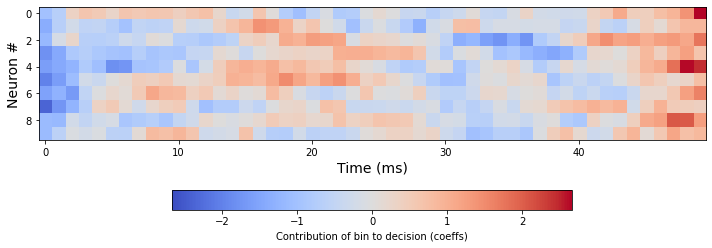

Fold 2 of 5
   Validation accuracy of 0.88


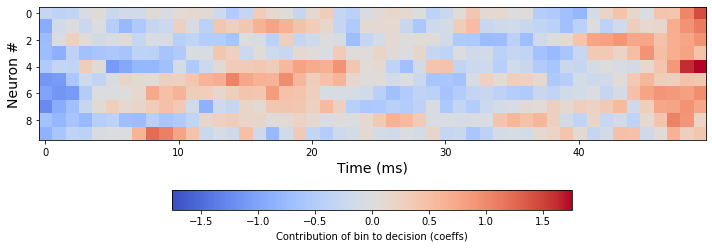

Fold 3 of 5
   Validation accuracy of 0.8


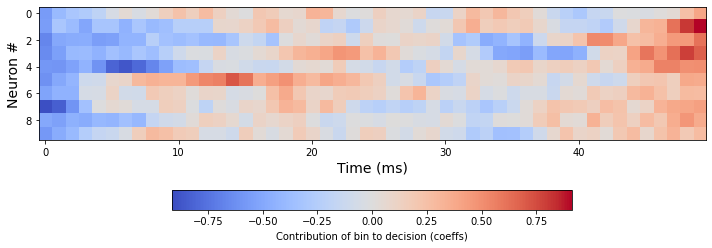

Fold 4 of 5
   Validation accuracy of 0.84


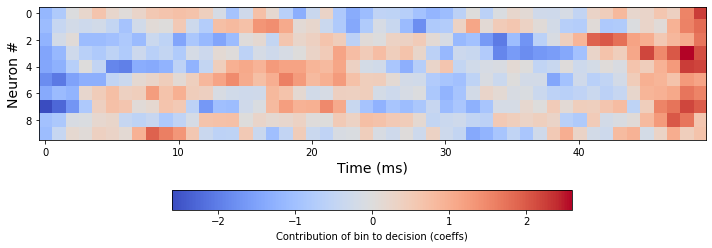

Mean validation accuracy: 0.828


In [14]:
scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_Xi = training_X[fold]
  training_Yi = training_Y[fold]
  
  val_Xi = val_X[fold]
  val_Yi = val_Y[fold]
  
  # re-initialize the logistic regression model
  logreg_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                               max_iter = 1000, C=1e-6)
  # fit and score on training
  logreg_model.fit(training_Xi, training_Yi)
  logreg_model.score(training_Xi, training_Yi)

  # score on the validation data
  accuracy = logreg_model.score(val_Xi, val_Yi)
  scores.append(accuracy)
  
  print("   Validation accuracy of {}".format( accuracy ))
  
  myplotfns.plot_coefs(logreg_model, n_neurons, n_bins_per_trial)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

This regularization value did not seem to make much of a difference.

### Test a range of regularization penalties, 'C'


In [21]:
# logarithmic schedule of Cs. 
Cs_to_test = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

# flatten
training_X_flat = np.reshape(training_X, (len(training_X),-1)) # keep first dim, flatten rest
training_Y_flat = np.reshape(training_Y, (len(training_Y),-1))

validation_accuracy_vs_C = []
for C in Cs_to_test:
  
  # get the mean score on k-fold cross-validation using your function above
  mean_validation_accuracy = mycrossval.get_kfold_validation_score(X, decisions, C)
  
  validation_accuracy_vs_C.append(mean_validation_accuracy)
  

(0.8, 1.0)

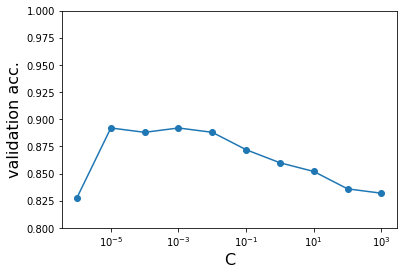

In [22]:
# plot
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
plt.ylim([.8,1])

c=1e-5 appears to be most optimal, appears to make stepwise change but otherwise no major difference. 

# Compare linear and DNN models on neural data

check if GPU ready

In [23]:
!nvidia-smi

Tue Jan 11 06:35:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
def compute_accuracy(val_spikes, val_choices, model):
  predictions = model.predict(val_spikes)
  accuracy = np.sum(predictions == val_choices) / len(predictions)
  return accuracy

## initial test of training models
An initial quick-and-dirty 1-fold split to test out loading models, train a few epochs, etc.

Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)

In [25]:
# split training and validation data
split = int(len(binned_spikes)*4/5)

training_spikes = binned_spikes[:split]
validation_spikes = binned_spikes[split:]

training_choices = choices[:split]
validation_choices = choices[split:]

In [26]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 100,
                                                    dropout = 0,
                                                    num_epochs =3,
                                                    verbose = 1)

my_RNN_classifier.fit(training_spikes, training_choices)


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


Epoch 1/3
6/6 [==============================] - 5s 685ms/step - loss: 1.0709 - accuracy: 0.4451
Epoch 2/3
6/6 [==============================] - 4s 681ms/step - loss: 0.8480 - accuracy: 0.6374
Epoch 3/3
6/6 [==============================] - 4s 704ms/step - loss: 0.7101 - accuracy: 0.7143

 validation accuracy: 28.26086956521739 %


In [27]:
# GRU
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs = 3,
                                              verbose = 1)

GRU_classifier.fit(training_spikes, training_choices)


Epoch 1/3
6/6 [==============================] - 23s 3s/step - loss: 1.0896 - accuracy: 0.3956
Epoch 2/3
6/6 [==============================] - 21s 3s/step - loss: 1.0484 - accuracy: 0.4835
Epoch 3/3
6/6 [==============================] - 21s 3s/step - loss: 1.0217 - accuracy: 0.4725


In [28]:
# accuracy 
predictions = GRU_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)


0.17391304347826086


In [29]:
#LSTM
LSTM_classifier = decoders.LSTMClassification(units = 100, 
                                              dropout = 0.1,
                                              num_epochs = 3,
                                              verbose = 1)

LSTM_classifier.fit(training_spikes, training_choices)

Epoch 1/3
6/6 [==============================] - 26s 4s/step - loss: 1.0920 - accuracy: 0.4121
Epoch 2/3
6/6 [==============================] - 23s 4s/step - loss: 1.0351 - accuracy: 0.4780
Epoch 3/3
6/6 [==============================] - 23s 4s/step - loss: 1.0090 - accuracy: 0.4725


In [30]:
# accuracy
predictions = LSTM_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

0.17391304347826086


XGBoost is powerful but does not model time dependencies, thus have to flatten into shape (n_trials, n_neurons x n_time_bins)

In [31]:
# XGBoost
flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1)) # keep first dim, flatten rest
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now train it like above
XGBoost_classifier = decoders.XGBoostClassification()

XGBoost_classifier.fit(flat_train_data, training_choices)

# accuracy
predictions = XGBoost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

0.6739130434782609


Interestingly, XGBoost performing ok already (67% accuracy vs. 30% expected by chance), whereas simple RNN may be variability with only a few epochs and no crossvalidation (40% vs. 30% expected by chance)

In [32]:
# dict to store scores
scores_all = {'logreg': [], 'RNN': [], 'GRU': [], 'LSTM': [], 'XB': []}

## Implement cross validation and regularization

In [33]:
# get training and validation data
(training_Xs, training_Ys), (val_Xs, val_Ys) = mycrossval.get_test_train_splits(binned_spikes, choices)

## logistic regression

In [34]:
# 5-fold logistic regression
val_scores = []
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    logreg_model = linear_model.LogisticRegression(penalty='l2',
                                                 solver = 'lbfgs',
                                                 max_iter = 1000,
                                                 C=1e-5)
    # fit and score on training
    logreg_model.fit(training_X, training_Y)
    train_accuracy = logreg_model.score(training_X,training_Y)

    # score on the validation data
    val_accuracy = logreg_model.score(validation_X,validation_Y)
    val_scores.append(val_accuracy)

    print("   training set accuracy of {}".format( train_accuracy ))
    print("   validation set accuracy of {}".format( val_accuracy ))

scores_all['logreg'] = np.mean(val_scores) # store
print("Mean validation accuracy: {}".format(np.mean(val_scores)))


Fold 0 of 5
   training set accuracy of 0.7377049180327869
   validation set accuracy of 0.4222222222222222
Fold 1 of 5
   training set accuracy of 0.46994535519125685
   validation set accuracy of 0.17777777777777778
Fold 2 of 5
   training set accuracy of 0.4262295081967213
   validation set accuracy of 0.35555555555555557
Fold 3 of 5
   training set accuracy of 0.73224043715847
   validation set accuracy of 0.8222222222222222
Fold 4 of 5
   training set accuracy of 0.4262295081967213
   validation set accuracy of 0.35555555555555557
Mean validation accuracy: 0.42666666666666664


## simple RNN

In [35]:
mean_train_accuracy = []
mean_val_accuracy = []

for fold in range(5):
    print("Fold {} of 5".format(fold))
    # by fold
    training_X = training_Xs[fold]
    training_Y = training_Ys[fold]
    validation_X = val_Xs[fold]
    validation_Y = val_Ys[fold]
    #flattened
    training_X_flat = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y_flat = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X_flat = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y_flat = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    RNN = decoders.SimpleRNNClassification(units = 1000,
                                            dropout = 0.1,
                                            num_epochs =1,
                                            verbose = 1)
    # fit and score on training data
    RNN.fit(training_X, training_Y)
    RNN_train_accuracy = compute_accuracy(training_X, training_Y, RNN)
    mean_train_accuracy.append(RNN_train_accuracy)

    # score on the validation data
    RNN_val_accuracy = compute_accuracy(validation_X, validation_Y, RNN)
    mean_val_accuracy.append(RNN_val_accuracy)

    print("RNN training set accuracy: {}".format(RNN_train_accuracy))
    print("RNN validation set accuracy: {}".format(RNN_val_accuracy))

scores_all['RNN'] = RNN_val_accuracy # store

print("Mean train accuracy: {}".format(np.mean(mean_train_accuracy)))
print("Mean validation accuracy: {}".format(np.mean(mean_val_accuracy)))



Fold 0 of 5
6/6 [==============================] - 8s 1s/step - loss: 1.7023 - accuracy: 0.3661
RNN training set accuracy: 0.2568306010928962
RNN validation set accuracy: 0.4888888888888889
Fold 1 of 5
6/6 [==============================] - 8s 1s/step - loss: 1.3873 - accuracy: 0.3661
RNN training set accuracy: 0.273224043715847
RNN validation set accuracy: 0.17777777777777778
Fold 2 of 5
6/6 [==============================] - 8s 1s/step - loss: 1.4433 - accuracy: 0.3661
RNN training set accuracy: 0.4207650273224044
RNN validation set accuracy: 0.3333333333333333
Fold 3 of 5
6/6 [==============================] - 8s 1s/step - loss: 1.3765 - accuracy: 0.3825
RNN training set accuracy: 0.34972677595628415
RNN validation set accuracy: 0.5111111111111111
Fold 4 of 5
6/6 [==============================] - 8s 1s/step - loss: 1.5308 - accuracy: 0.3279
RNN training set accuracy: 0.3989071038251366
RNN validation set accuracy: 0.4
Mean train accuracy: 0.33989071038251367
Mean validation accurac

In [36]:
# GRU
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs = 20,
                                              verbose = 1)

GRU_classifier.fit(training_spikes, training_choices)


Epoch 1/20
6/6 [==============================] - 21s 3s/step - loss: 1.0799 - accuracy: 0.4451
Epoch 2/20
6/6 [==============================] - 19s 3s/step - loss: 1.0385 - accuracy: 0.4780
Epoch 3/20
6/6 [==============================] - 19s 3s/step - loss: 1.0089 - accuracy: 0.4725
Epoch 4/20
6/6 [==============================] - 19s 3s/step - loss: 0.9864 - accuracy: 0.4780
Epoch 5/20
6/6 [==============================] - 19s 3s/step - loss: 0.9703 - accuracy: 0.4780
Epoch 6/20
6/6 [==============================] - 20s 3s/step - loss: 0.9382 - accuracy: 0.5110
Epoch 7/20
6/6 [==============================] - 19s 3s/step - loss: 0.9075 - accuracy: 0.5275
Epoch 8/20
6/6 [==============================] - 20s 3s/step - loss: 0.8594 - accuracy: 0.5604
Epoch 9/20
6/6 [==============================] - 20s 3s/step - loss: 0.8581 - accuracy: 0.6429
Epoch 10/20
6/6 [==============================] - 20s 3s/step - loss: 0.8160 - accuracy: 0.6319
Epoch 11/20
6/6 [======================

In [37]:
# accuracy 
predictions = GRU_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)


0.34782608695652173


In [38]:
#LSTM
LSTM_classifier = decoders.LSTMClassification(units = 100, 
                                              dropout = 0.1,
                                              num_epochs = 20,
                                              verbose = 1)

LSTM_classifier.fit(training_spikes, training_choices)

Epoch 1/20
6/6 [==============================] - 26s 4s/step - loss: 1.0856 - accuracy: 0.4341
Epoch 2/20
2/6 [=========>....................] - ETA: 15s - loss: 1.0807 - accuracy: 0.3750

KeyboardInterrupt: ignored

In [ ]:
# accuracy
predictions = LSTM_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

XGBoost is powerful but does not model time dependencies, thus have to flatten into shape (n_trials, n_neurons x n_time_bins)

In [ ]:
# XGBoost
flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1)) # keep first dim, flatten rest
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now train it like above
XGBoost_classifier = decoders.XGBoostClassification()

XGBoost_classifier.fit(flat_train_data, training_choices)

# accuracy
predictions = XGBoost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

## results
- appears logistic regression does not perform much better than chance (42% vs. 30%). This could mean previous strangely high accuracy could be overfit d/t outsize influence of noise or outliers, and this was ameliorated with more expectedly ameliorated with regularization, crossvalidation

- Complicated decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small and potentially noisy real-world datasets
- Interestingly, this suggests cellular information integrated across brain regions may work together for decision-making, a phenomenon that was previously technologically inaccessible
- DNNs outperform statistical models (logistic regression accuracy 30-40% whereas DNNs 50-60% vs. 30% expected by chance)
- DNNS are prone to overfitting and require additional considerations, e.g. crossvalidation or regularization
- XGBoost appears to be the best performing DNN (67% accuracy vs. 30% expected by chance)

# Validate RNN further with similated data as described above


Shape: n_trials x n_neurons x n_timebins

In [ ]:
# resplit data
split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

training_data = np.swapaxes(training_data, 1, 2)
validation_data = np.swapaxes(validation_data, 1, 2)

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


In [ ]:
# instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 1)

In [ ]:
# fit
my_RNN_classifier.fit(training_data, training_decisions)

In [ ]:
# predict
predictions = my_RNN_classifier.predict(validation_data)
predictions

In [ ]:
#my_RNN_classifier.score(validation_data, validation_decisions)
accuracy = np.sum(predictions == validation_decisions) / len(predictions)
print(accuracy)


Interestingly, similar results here between linear models and RNN, suggesting models should be implemented correctly and no obvious abnormalities

# Further validate and re-run with other sessions of neuropixels data
This can take about 30 seconds to download the ~600M of data into your working folder, and 10 minutes to run the script.


In [ ]:
session = "Cori_2016-12-14/"

!wget -np -r -nv http://data.cortexlab.net/taskData/$session
!mv data.cortexlab.net/taskData/ .

Now we'll extract this data into Python in the form of a dictionary.

In [ ]:
from tqdm import tqdm as tqdm

def load_data(session):
    """Takes a session in relative path ./taskData and loads it as a dictionary."""
    files = !ls taskData/$session/*.npy
    all_files = {}
    for file in files:
        filename = file.split("/")[2][:-4]
        all_files[filename] = np.load(file)
    return all_files
  
def count_neurons(time_interval, all_files):
    """In this time interval, return the neurons with nonzero spikes, and how many
    
    Returns (ids, counts)
    """
    
    
    t1,t2 = time_interval
    
    trial_spikes = all_files['spikes.times']

    interval = (trial_spikes > t1) & (trial_spikes < t2)

    trial_spikes = trial_spikes[interval]
    ids = all_files['spikes.clusters'][interval]
    
    # ids has all the info we need
    return np.unique(ids, return_counts = True)
    
    


def bin_into_array(all_files, time_before_response=1, n_bins = 50):
    
    ids = all_files['spikes.clusters']
    idList = np.unique(ids)
    
    n_trials = len(all_files['trials.response_choice'])
    n_neurons = len(idList)
    
    choices = np.reshape(all_files['trials.response_choice'],-1)
    data = np.zeros((n_trials, n_neurons, n_bins))
    
    time_resolution = time_before_response/ float(n_bins)
    print(time_resolution)
    
    for trial in tqdm(range(n_trials)):
        end_time = all_files['trials.response_times'][trial]
        start_time = end_time - time_before_response
        
        print(time_resolution)
        
        for b in range(n_bins):
        
            which_neurons, n_spikes = count_neurons((start_time + b*time_resolution,
                                            start_time + (b+1)*time_resolution),
                                          all_files)
            
            data[trial,which_neurons,b] = n_spikes
            
    return data, choices


In [ ]:
session = "Cori_2016-12-14"
all_files = load_data(session)


In [ ]:
data, choices = bin_into_array(all_files)
data.shape

In [ ]:
#clean up the data we aren't using
!rm -r data.cortexlab.net/